# Artificial neural network

In [1]:
#imports
from preprocessing.preprocessing import get_preprocessed_brfss_train_test_split_one_hot_encoded, get_preprocessed_brfss_dataset

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data_utils

import matplotlib.pyplot as plt

import numpy as np

In [2]:
#constants
batch_size = 25

In [3]:
use_mps = False
use_cuda = False

device = torch.device("cpu")

if torch.has_mps and use_mps:
    device = torch.device("mps")
    print("Torch mps activated")

if torch.has_cuda and use_cuda:
    device = torch.device("cuda")
    print("Torch cuda activated")

Looking at the dataset it becomes clear that it is imbalanced

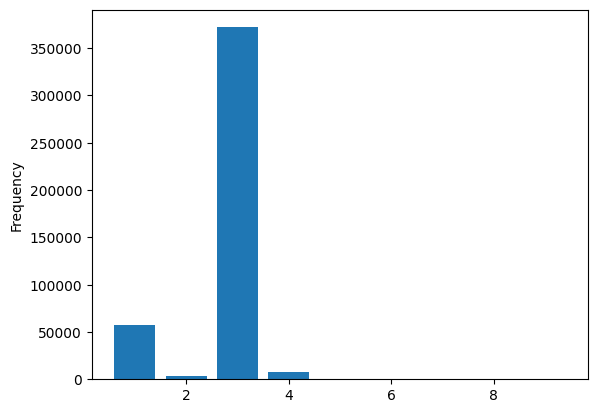

In [4]:
train_dataset, target = get_preprocessed_brfss_dataset()
target = target.squeeze()
class_dist = target.value_counts()
plt.bar(class_dist.index, class_dist)
plt.ylabel("Frequency")
plt.show()

In [5]:
data_train, data_test, target_train, target_test = get_preprocessed_brfss_train_test_split_one_hot_encoded()
target_train.head()

,Yes,"Yes, but only during pregnancy",No,"No, but pre-diabetes",Don't know,Refused
104065,1.0,0.0,0.0,0.0,0.0,0.0
11428,0.0,0.0,1.0,0.0,0.0,0.0
163452,0.0,0.0,1.0,0.0,0.0,0.0
184441,0.0,0.0,1.0,0.0,0.0,0.0
218001,0.0,0.0,1.0,0.0,0.0,0.0


Create torch data loader

In [6]:
train_dataset = data_utils.TensorDataset(torch.tensor(np.array(data_train)).float(),
                                         torch.tensor(np.array(target_train)).float())
test_dataset = data_utils.TensorDataset(torch.tensor(np.array(data_test)).float(),
                                        torch.tensor(np.array(target_test)).float())

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

Create artificial net, define loss function and define optimizer

In [7]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(317, 500)
        self.fc2 = nn.Linear(500, 1500)
        self.fc3 = nn.Linear(1500, 500)
        self.fc4 = nn.Linear(500, 6)

    def forward(self, x):
        x = F.leaky_relu(self.fc1(x), 0.01)
        x = F.leaky_relu(self.fc2(x), 0.01)
        x = F.leaky_relu(self.fc3(x), 0.01)
        x = F.softmax(self.fc4(x))
        return x


net = Net()
net.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.0002, momentum=0.9)

Training loop

In [8]:
for epoch in range(2):

    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):

        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % 2000 == 1999:  # print every 2000 batches
            print(f'[{epoch + 1}, {(i + 1) * batch_size}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

print('Finished Training')

/var/folders/fv/hdmdsw6s3fv_72w1tfp22w9m0000gn/T/ipykernel_67837/3182606017.py:13: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.softmax(self.fc4(x))


[1, 50000] loss: 1.204
[1, 100000] loss: 1.200
[1, 150000] loss: 1.201
[1, 200000] loss: 1.199
[1, 250000] loss: 1.200
[1, 300000] loss: 1.200
[1, 350000] loss: 1.201
[2, 50000] loss: 1.202
[2, 100000] loss: 1.202
[2, 150000] loss: 1.199
[2, 200000] loss: 1.200
[2, 250000] loss: 1.201
[2, 300000] loss: 1.201
[2, 350000] loss: 1.201
Finished Training


In [9]:
correct = 0
total = 0

with torch.no_grad():
    for i, data in enumerate(test_loader, 0):
        inputs, labels = data

        outputs = net(inputs)
        _, predicted = torch.max(outputs.data, 1)
        _, labels = torch.max(labels.data, 1)

        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy : {100 * correct // total} %')

/var/folders/fv/hdmdsw6s3fv_72w1tfp22w9m0000gn/T/ipykernel_67837/3182606017.py:13: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.softmax(self.fc4(x))


Accuracy : 84 %
